# Analysing the data for prediction purposes

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import date, datetime
from dateutil.parser import parse

In [2]:
data = pd.read_csv('Cristano_Ronaldo_Final_v1/Data.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
sample = pd.read_csv('Cristano_Ronaldo_Final_v1/sample_submission.csv')
data['shot_id_number'] = range(1, len(data)+1)

In [3]:
data.select_dtypes(include=['object']).head(10)

,game_season,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,home/away,lat/lng,type_of_shot,type_of_combined_shot
0,2000-01,Right Side(R),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 30,NaN
1,2000-01,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 45,NaN
2,2000-01,Left Side Center(LC),Mid Range,16-24 ft.,Manchester United,2000-10-31,NaN,"45.539131, -122.651648",shot - 25,NaN
3,2000-01,Right Side Center(RC),Mid Range,16-24 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 3
4,2000-01,Center(C),Goal Area,Less Than 8 ft.,NaN,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 1
5,NaN,Left Side(L),Mid Range,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 17,NaN
6,2000-01,Center(C),Goal Area,Less Than 8 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 4
7,2000-01,Center(C),Goal Area,Less Than 8 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",NaN,shot - 3
8,2000-01,Left Side(L),Goal Line,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 36,NaN
9,2000-01,Center(C),Goal Line,8-16 ft.,Manchester United,2000-10-31,MANU @ POR,"45.539131, -122.651648",shot - 44,NaN


### Converting non-integer fields into integers

In [4]:
data.game_season = data.game_season.fillna(method = 'ffill')
le_gs = LabelEncoder()
le_gs.fit(data.game_season.tolist())
print(le_gs.classes_)
new_col = le_gs.transform(data.game_season.tolist())
data['game_season'] = new_col

['1996-97' '1997-98' '1998-99' '1999-00' '2000-01' '2001-02' '2002-03'
 '2003-04' '2004-05' '2005-06' '2006-07' '2007-08' '2008-09' '2009-10'
 '2010-11' '2011-12' '2012-13' '2013-14' '2014-15' '2015-16']


In [5]:
# Columns that needs its rows to be encoded into labels
change_cols = ['area_of_shot','shot_basics','range_of_shot','team_name']

In [6]:
le_list = []
for i in range (0,len(change_cols)):
    le = LabelEncoder()
    le.fit(data[change_cols[i]].tolist())
    new_col = le.transform(data[change_cols[i]].tolist())
    data[change_cols[i]] = new_col
    le_list.append(le)

In [7]:
# Function to separate home/away into two separate columns
def separate_home_away_col(lines):
    away = []
    home = []
    for l in lines:
        l = str(l)
        if (l == 'nan'):
            away.append(None)
            home.append(None)
        else:
            tokens = l.split(' ')
            if (tokens[1] == '@'):
                away.append(tokens[2])
                home.append(None)
            else:
                away.append(None)
                home.append(tokens[2])
    return away, home

In [8]:
away, home = separate_home_away_col(list(data['home/away']))
data['home'] = home
data['away'] = away
data.drop('home/away', axis = 1, inplace = True)

In [9]:
data[['home', 'away']] = data[['home', 'away']].fillna(0)
le_ha = LabelEncoder()
le_ha.fit((data['home'].tolist() + data['away'].tolist()))
new_col = le_ha.transform(data['home'].tolist())
data['home'] = new_col
new_col = le_ha.transform(data['away'].tolist())
data['away'] = new_col

In [10]:
def separate_lat_long(lines):
    lat = []
    long = []
    for l in lines:
        l = str(l)
        if (l == 'nan'):
            lat.append(None)
            long.append(None)
        else:
            tokens = l.split(',')
            lat.append(tokens[0])
            long.append(tokens[1])
    return lat,long

In [11]:
lat, long = separate_lat_long(list(data['lat/lng']))
data['lat'] = lat
data['long'] = long
data.drop('lat/lng', axis = 1, inplace = True)

In [12]:
# Observing that type_of_shot and type_of_combined_shot complement each other
print((data['type_of_combined_shot'][data['type_of_shot'].isnull()]).isnull().sum())
# We can try by combining them together

0


In [13]:
data['type_of_shot'] = data['type_of_shot'].fillna(data['type_of_combined_shot'])
data.drop('type_of_combined_shot', axis = 1, inplace = True)
data['type_of_shot'] = data['type_of_shot'].apply(lambda x: x.split('-')[1])

In [14]:
le_mi = LabelEncoder()
le_mi.fit(data.match_id.tolist())
print(le_mi.classes_)
new_col = le_mi.transform(data.match_id.tolist())
data['match_id'] = new_col

[20000012 20000019 20000047 ... 49900086 49900087 49900088]


In [15]:
# Function to calculate number of days before today
def calc_days(g_date):
    if (type(g_date) == str):
        tokens = g_date.split('-')
        given_date = date(int(tokens[0]), int(tokens[1]), int(tokens[2]))
        today = date.today()
        diff = today - given_date
        return diff.days
    else:
        return None

In [16]:
data.date_of_game = data.date_of_game.apply(lambda x: calc_days(x))

In [17]:
data.loc[:, data.columns != 'is_goal'] = data.loc[:, data.columns != 'is_goal'].fillna(method = 'ffill')

# Scaling the data using Standard Scaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data.loc[:, data.columns != 'is_goal'])
scaled_df = pd.DataFrame(scaled_df, columns=data.loc[:, data.columns != 'is_goal'].columns)
scaled_df['is_goal'] = data['is_goal']
scaled_df['shot_id_number'] = data['shot_id_number']
scaled_df = scaled_df.set_index('shot_id_number')

In [18]:
#data.iloc[:10,8:]
scaled_df.iloc[:10,6:]

,game_season,remaining_sec,distance_of_shot,area_of_shot,shot_basics,range_of_shot,team_name,date_of_game,type_of_shot,match_id,...,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1,home,away,lat,long,is_goal
shot_id_number,,,,,,,,,,,,,,,,,,,,,
1,-1.112246,-0.073836,0.485802,1.438591,0.457438,-1.203237,-0.229428,1.17423,0.807640,-1.638381,...,-0.278099,-0.504139,0.966261,0.508211,-0.042006,-0.759041,1.567925,1.082705,-2.094516,NaN
2,-1.112246,-0.360043,0.165341,0.016172,0.457438,-0.017726,-0.229428,1.17423,1.679298,-1.638381,...,-0.278099,-0.504139,0.346438,-0.570533,-0.201613,-0.759041,1.567925,1.082705,-2.094516,0.0
3,-1.112246,0.956510,0.272161,-0.457968,0.457438,-1.203237,-0.229428,1.17423,0.517087,-1.638381,...,2.534447,-0.504139,-0.472111,0.827198,0.830511,-0.759041,-0.788419,1.082705,-2.094516,1.0
4,-1.112246,1.357200,0.913083,0.964451,0.457438,-1.203237,-0.229428,1.17423,-0.761346,-1.638381,...,2.534447,-0.504139,3.012633,0.434508,0.170803,-0.759041,1.567925,1.082705,-2.094516,0.0
5,-1.112246,-0.531767,-1.436965,-0.932108,-1.412206,1.167784,4.358675,1.17423,-0.877567,-1.638381,...,0.832762,-0.470365,-0.472111,-0.671037,-0.999646,-0.759041,1.567925,1.082705,-2.094516,1.0
6,-1.112246,0.212372,0.058520,0.016172,0.457438,-0.017726,-0.229428,1.17423,0.052202,-1.638381,...,-0.312132,-0.436591,-0.472111,-0.671037,-0.254815,-0.759041,1.567925,1.082705,-2.094516,0.0
7,-1.112246,1.357200,-1.436965,-0.932108,-1.412206,1.167784,-0.229428,1.17423,-0.703235,-1.638381,...,-0.346166,-0.436591,-0.472111,2.451291,2.692589,-0.759041,1.567925,1.082705,-2.094516,1.0
8,-1.112246,-1.333147,-1.223324,-0.932108,-1.412206,1.167784,-0.229428,1.17423,-0.761346,-1.638381,...,1.717638,-0.436591,-0.472111,-1.140056,-0.893242,-0.759041,1.567925,1.082705,-2.094516,NaN
9,-1.112246,-0.932457,-0.155120,0.016172,-0.944795,-0.017726,-0.229428,1.17423,1.156303,-1.638381,...,-0.414233,-0.436591,-0.472111,-0.905547,-0.361219,-0.759041,1.567925,1.082705,-2.094516,1.0


In [19]:
# Spliting the data into train and test data
test = scaled_df[scaled_df['is_goal'].isnull()]
train = scaled_df[scaled_df['is_goal'].notnull()]

#### Plotting the correlation matrix to find useful features

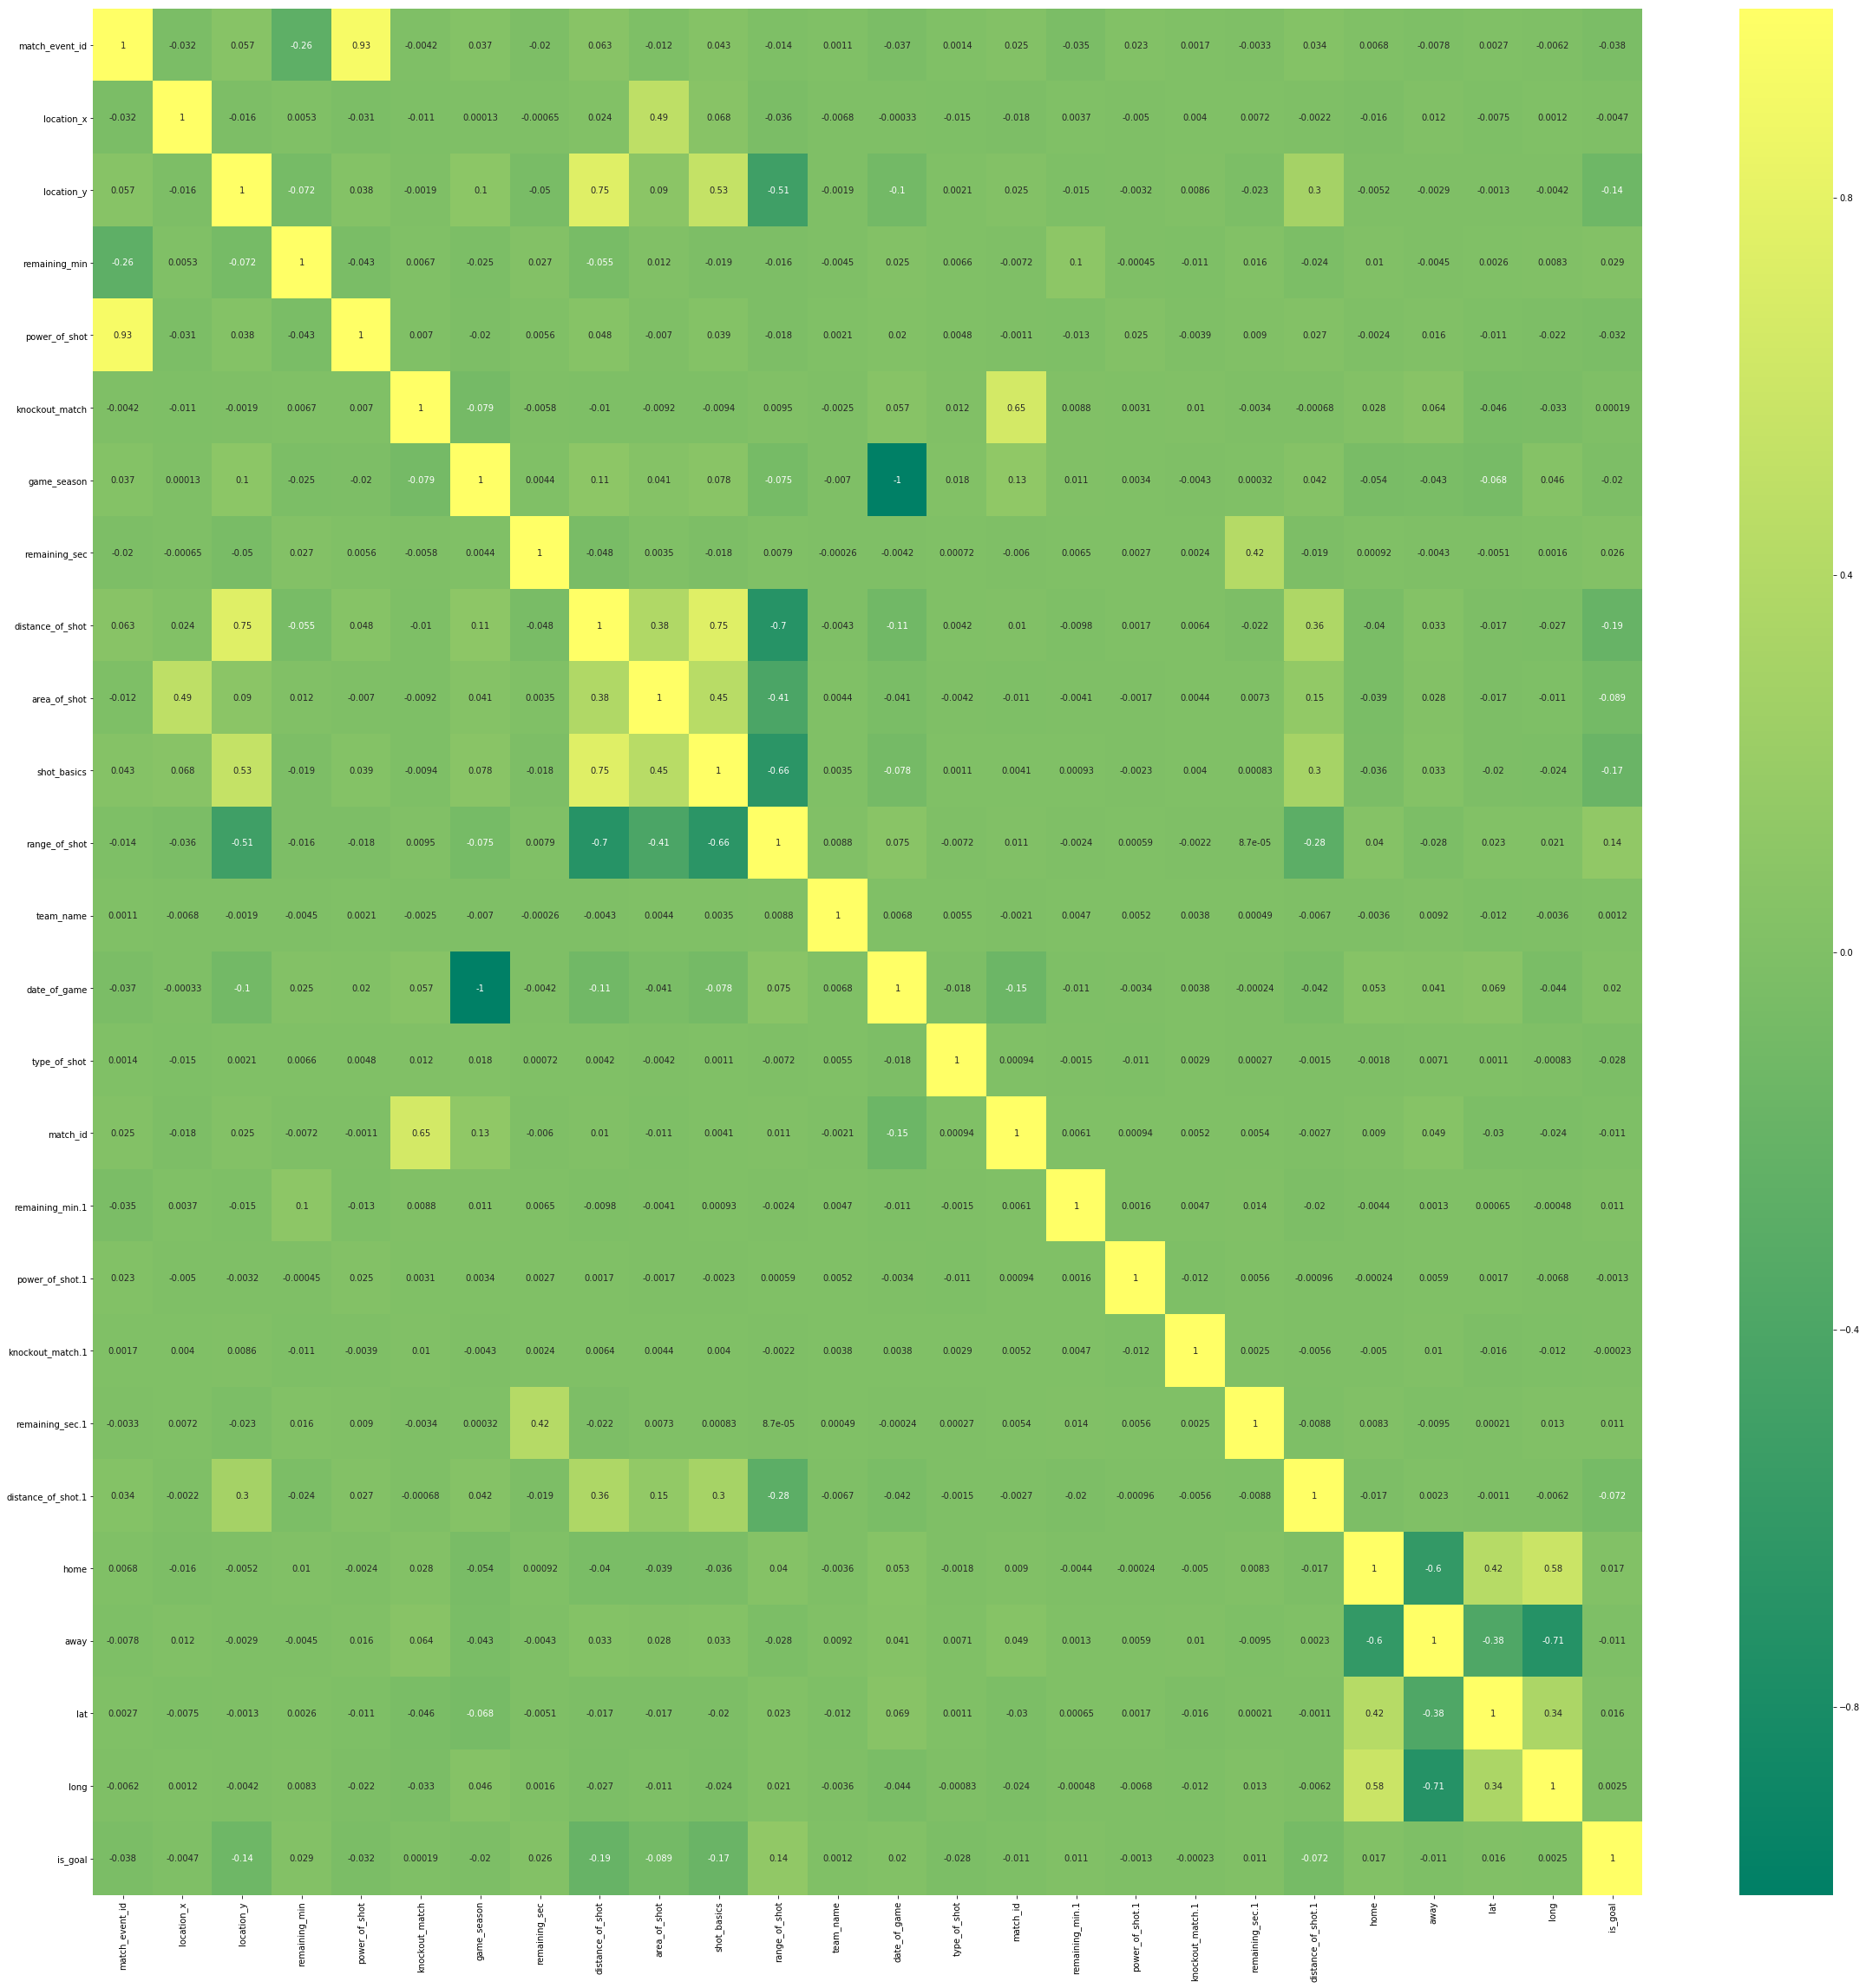

In [20]:
corrmat = train.corr()
filteredCorrMat_features = corrmat.index[abs(corrmat['is_goal']).notnull()]
plt.figure(figsize=(40,40))
sns.heatmap(train[filteredCorrMat_features].corr(),annot=True,cmap='summer')

In [21]:
# Correlation matrix
train.corr()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,area_of_shot,...,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1,home,away,lat,long,is_goal
match_event_id,1.000000,-0.032209,0.057159,-0.261027,0.934347,-0.004245,0.037317,-0.019831,0.062998,-0.011867,...,-0.035139,0.023087,0.001671,-0.003318,0.034349,0.006752,-0.007794,0.002711,-0.006155,-0.037611
location_x,-0.032209,1.000000,-0.015986,0.005339,-0.030638,-0.011400,0.000135,-0.000649,0.023557,0.487033,...,0.003725,-0.005017,0.004044,0.007170,-0.002153,-0.016403,0.011809,-0.007540,0.001172,-0.004664
location_y,0.057159,-0.015986,1.000000,-0.071753,0.038005,-0.001923,0.099819,-0.049952,0.745047,0.090211,...,-0.014559,-0.003227,0.008564,-0.023401,0.297019,-0.005245,-0.002892,-0.001264,-0.004192,-0.139041
remaining_min,-0.261027,0.005339,-0.071753,1.000000,-0.043150,0.006674,-0.024621,0.026774,-0.055023,0.011551,...,0.101831,-0.000449,-0.011159,0.016101,-0.024350,0.010398,-0.004497,0.002569,0.008253,0.029342
power_of_shot,0.934347,-0.030638,0.038005,-0.043150,1.000000,0.007009,-0.020368,0.005582,0.048053,-0.006984,...,-0.013264,0.024760,-0.003924,0.008969,0.026902,-0.002432,0.015665,-0.010824,-0.021952,-0.031606
knockout_match,-0.004245,-0.011400,-0.001923,0.006674,0.007009,1.000000,-0.079340,-0.005793,-0.010121,-0.009191,...,0.008777,0.003080,0.010273,-0.003421,-0.000679,0.027699,0.063662,-0.045625,-0.032769,0.000192
game_season,0.037317,0.000135,0.099819,-0.024621,-0.020368,-0.079340,1.000000,0.004447,0.108489,0.040756,...,0.010518,0.003406,-0.004317,0.000322,0.041653,-0.054098,-0.043004,-0.068395,0.046116,-0.020060
remaining_sec,-0.019831,-0.000649,-0.049952,0.026774,0.005582,-0.005793,0.004447,1.000000,-0.048191,0.003453,...,0.006539,0.002743,0.002431,0.421410,-0.019366,0.000920,-0.004289,-0.005103,0.001611,0.025862
distance_of_shot,0.062998,0.023557,0.745047,-0.055023,0.048053,-0.010121,0.108489,-0.048191,1.000000,0.380273,...,-0.009844,0.001667,0.006351,-0.021748,0.361775,-0.040459,0.033414,-0.017306,-0.026510,-0.190623
area_of_shot,-0.011867,0.487033,0.090211,0.011551,-0.006984,-0.009191,0.040756,0.003453,0.380273,1.000000,...,-0.004053,-0.001675,0.004437,0.007342,0.146113,-0.039054,0.027529,-0.017362,-0.011147,-0.088599


In [47]:
# Selecting the important features
new_data = data[['match_event_id','location_y','power_of_shot','distance_of_shot', 'area_of_shot', 'shot_basics','range_of_shot','distance_of_shot.1','is_goal']]

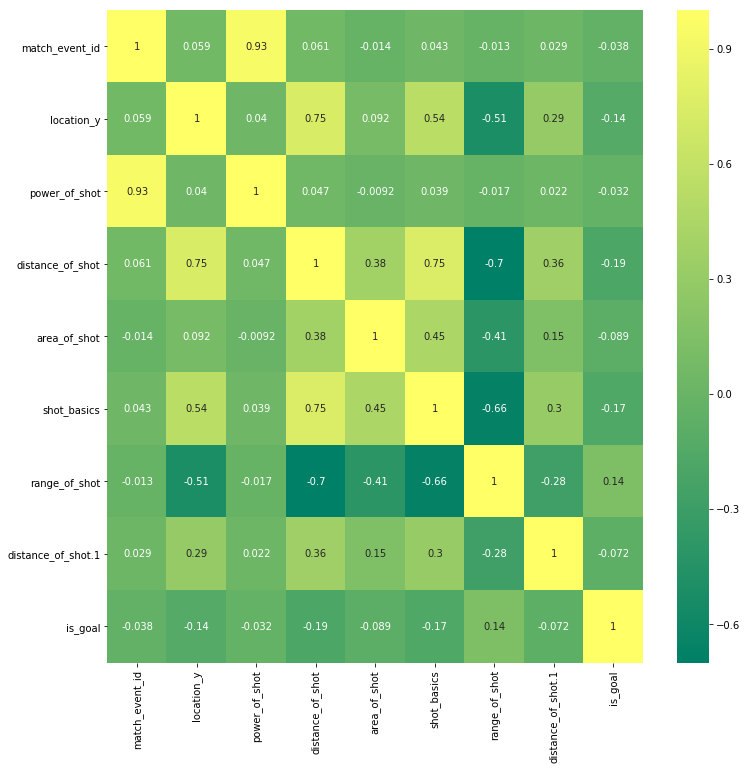

In [48]:
corrmat = new_data.corr()
filteredCorrMat_features = corrmat.index[abs(corrmat['is_goal']).notnull()]
plt.figure(figsize=(12,12))
sns.heatmap(new_data[filteredCorrMat_features].corr(),annot=True,cmap='summer')

In [24]:
# full_test = data[data['is_goal'].isnull()]
# full_train = data[data['is_goal'].notnull()]

# full_train.loc[:, full_train.columns != 'is_goal'] = full_train.loc[:, full_train.columns != 'is_goal'].fillna(method = 'ffill')
# full_test.loc[:, full_test.columns != 'is_goal'] = full_test.loc[:, full_test.columns != 'is_goal'].fillna(method = 'ffill')

In [65]:
#train.iloc[:,:-1] = train.iloc[:,:-1].fillna(method = 'ffill')
#test.iloc[:,:-1] = test.iloc[:,:-1].fillna(method = 'ffill')

In [26]:
# Print statistics
print('Orig: '+ str(len(data)))
print('test stats')
print(test.is_goal.describe())
print('Length of the dataset : '+str(len(test)))
print('train stats')
print(train.is_goal.describe())
print(train.is_goal.value_counts())
print('Length of the dataset : '+str(len(train)))

Orig: 30697
test stats
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: is_goal, dtype: float64
Length of the dataset : 6268
train stats
count    24429.000000
mean         0.445331
std          0.497013
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: is_goal, dtype: float64
0.0    13550
1.0    10879
Name: is_goal, dtype: int64
Length of the dataset : 24429


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, recall_score, precision_score
from xgboost import XGBRegressor
from math import sqrt

/Users/rockstar/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [28]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:,:-1], train['is_goal'], test_size=0.25)

In [29]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.47
Mean squared error: 0.24
R2 score: 0.04
Root Mean squared error: 0.49


In [30]:
logi = LogisticRegression()
logi.fit(X_train, y_train)
lp = logi.predict_proba(X_test)
y_pred = [x[0] for x in lp]

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.53
Mean squared error: 0.29
R2 score: -0.17
Root Mean squared error: 0.54


In [31]:
en = ElasticNet()
en.fit(X_train, y_train)
y_pred = en.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('R2 score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.49
Mean squared error: 0.25
R2 score: -0.00
Root Mean squared error: 0.50


In [32]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.44
Mean squared error: 0.29
Variance score: -0.17
Root Mean squared error: 0.54


In [33]:
ls = Lasso(alpha = 0.1)
ls.fit(X_train, y_train)
y_pred = ls.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.49
Mean squared error: 0.25
Variance score: -0.00
Root Mean squared error: 0.50


In [34]:
rdg = Ridge(alpha = 1.0)
rdg.fit(X_train, y_train)
y_pred = rdg.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.47
Mean squared error: 0.24
Variance score: 0.04
Root Mean squared error: 0.49


In [35]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.46
Mean squared error: 0.25
Variance score: -0.03
Root Mean squared error: 0.50


In [36]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.47
Mean squared error: 0.23
Variance score: 0.06
Root Mean squared error: 0.48


In [37]:
br = BaggingRegressor()
br.fit(X_train, y_train)
y_pred = br.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.45
Mean squared error: 0.25
Variance score: -0.02
Root Mean squared error: 0.50


In [38]:
etr = ExtraTreesRegressor()
etr.fit(X_train, y_train)
y_pred = etr.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.46
Mean squared error: 0.26
Variance score: -0.04
Root Mean squared error: 0.51


In [39]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error: 0.46
Mean squared error: 0.23
Variance score: 0.08
Root Mean squared error: 0.48


In [40]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1, gamma=0, subsample=0.50, colsample_bytree=1, max_depth=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Root Mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, y_pred)))

[19:10:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean absolute error: 0.46
Mean squared error: 0.27
Variance score: -0.07
Root Mean squared error: 0.51


## Prediction and storing in CSV file

In [41]:
lgr = LogisticRegression()
lgr.fit(train.iloc[:,:-1], train['is_goal'])
lp = lgr.predict_proba(test.iloc[:,:-1])
y_pred = [x[0] for x in lp]

In [45]:
temp = [[str(int(x)) for x in test.index], [x for x in list(y_pred)]]
df = pd.DataFrame(temp).transpose()
df.columns = ['shot_id_number', 'is_goal']

In [46]:
df.set_index('shot_id_number')
df.to_csv('Hari_Veeramallu_032699_prediction.csv', index = False)